In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sn

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setting up the device for GPU usage


from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
import nvidia_smi
nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)


print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 50962169856
Free memory: 39158480896
Used memory: 11803688960


In [4]:
print("Get memory info", torch.cuda.mem_get_info(device=None)) 
print("Get number of devices available: ", torch.cuda.device_count())

print("Memory stats about which device is free: ")

nvidia_smi.nvmlInit()

deviceCount = nvidia_smi.nvmlDeviceGetCount()
most_free = 0 
device_num = 0
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))
    if 100*info.free/info.total > most_free:
        most_free = 100*info.free/info.total 
        device_num = i 

nvidia_smi.nvmlShutdown()

print("Current Device:  ", torch.cuda.current_device()) 
print("Most free device: ", device_num)


Get memory info (37983027200, 50962169856)
Get number of devices available:  3
Memory stats about which device is free: 
Device 0: b'Quadro RTX 8000', Memory : (74.53% free): 50962169856(total), 37983027200 (free), 12979142656 (used)
Device 1: b'Quadro RTX 8000', Memory : (99.99% free): 50962169856(total), 50958106624 (free), 4063232 (used)
Device 2: b'Quadro RTX 8000', Memory : (5.26% free): 50962169856(total), 2678521856 (free), 48283648000 (used)
Current Device:   0
Most free device:  1


In [5]:
unique_labels = [
'circular reasoning', 
'false dilemma',
'ad populum',
'ad hominem', 
'fallacy of logic', 
'equivocation', 
'fallacy of extension', 
'fallacy of relevance', 
'fallacy of credibility', 
'intentional', 
'faulty generalization', 
    
'false causality'
]

In [6]:

MAX_LEN = 256

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [7]:
class LogicalFallacy(Dataset):
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.text = dataset.source_article
        self.targets = dataset.label
        self.max_len = max_len
        self.original_label = dataset.updated_label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        

        return {
            'sentence': text,
            
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    



In [9]:

def train_loop( train_loader, test_loader, label, test_data, epochs=5):
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  model = RobertaClass()
  model.to(device)
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

  test_answers = [[[],[]], [[],[]]]
  for epoch in range(epochs):
    for phase in ['Train', 'Test']:
      if(phase == 'Train'):
        model.train()
        loader = train_loader
      else:
        model.eval()
        loader = test_loader  
      epoch_loss = 0
      epoch_acc = 0
      len(loader)
      for steps, data in tqdm(enumerate(loader, 0)):
        sentence = data['sentence']
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
      
        outputs = model.forward(ids, mask, token_type_ids)

        loss = loss_function(outputs, targets)        
        
        epoch_loss += loss.detach()
        _, max_indices = torch.max(outputs.data, dim=1)
        bath_acc = (max_indices==targets).sum().item()/targets.size(0)
        epoch_acc += bath_acc

        if (phase == 'Train'):
          train_loss.append(loss.detach()) 
          train_accuracy.append(bath_acc)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        else:
          test_loss.append(loss.detach()) 
          test_accuracy.append(bath_acc)
          if epoch == epochs-1:
            for i in range(len(targets)):
              test_answers[targets[i].item()][max_indices[i].item()].append([
                                                                  sentence[i], 
                                                                  targets[i].item(), 
                                                                  max_indices[i].item()])

      print(f"{phase} Loss: {epoch_loss/steps}")
      print(f"{phase} Accuracy: {epoch_acc/steps}")
  
  torch.save(model, '../models/v3/articles/'+label+'_trained_roberta.pt')
  return test_answers


In [10]:
def driver_code(label, train_df, test_df):
   
    ars = [] 
    #for val in train_df['label']: 
        #if val=='0': 
            #ars.append(0) 
        #else: 
            
            #ars.append(1) 
    #train_df['label'] = ars
    train_set = LogicalFallacy(train_df, tokenizer, MAX_LEN)
    test_set = LogicalFallacy(test_df, tokenizer, MAX_LEN)

    train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

    test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
    train_loader = DataLoader(train_set, **train_params)
    test_loader = DataLoader(test_set, **test_params)

    
    value = train_loop( train_loader, test_loader, label,  test_df['updated_label'], epochs=4)
    return value
    

In [11]:
test_answers_list = []
for label in unique_labels:
    
    train_df = pd.read_csv('../data/train_data/v2/'+label+'_train.csv')

    test_df = pd.read_csv('../data/dev_data/v2/'+label+'_dev.csv')
    test_answers_list.append(driver_code(label, train_df, test_df)) 
    
    

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [63]:
import math
def truncate(f, n):
    
    return math.floor(f * 10 ** n) / 10 ** n

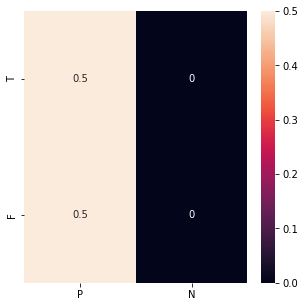

In [64]:
tp_list, tn_list, fp_list, fn_list = [], [], [], [] 
accuracy_list, precision_list, recall_list = [], [], [] 
for i in range(len(unique_labels)):
    test_df = pd.read_csv('../data/test_data/v2/'+label+'_test.csv')
    len_num = len(test_df)
    if len_num<=0:
        len_num = 1
    tp=len(test_answers_list[i][1][1])/len_num
    fn=len(test_answers_list[i][1][0])/len_num
    fp=len(test_answers_list[i][0][1])/len_num
    tn=len(test_answers_list[i][0][0])/len_num


    array_matrix = [[tp,tn], 
                    [fp,fn]]
    df_cm = pd.DataFrame(array_matrix, index = ['T', 'F'],
                    columns = ['P', 'N'])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)

    precision = truncate( tp / (tp + fp), 3) 
    recall = truncate( tp/ (tp + fn), 3)
    accuracy =truncate( tp+tn/(tp+tn+fp+fn), 3) 

    tp_list.append(truncate(tp,3)) 
    tn_list.append(truncate(tn, 3)) 
    fp_list.append(truncate(fp,3)) 
    fn_list.append(truncate(fn, 3))
    accuracy_list.append(accuracy) 
    recall_list.append(recall) 
    precision_list.append(precision) 

In [461]:
dictionary = {
    'fallacy class': unique_labels, 
    'accuracy': accuracy_list,
    'precision': precision_list, 
    'recall': recall_list, 
    'TP': tp_list, 
    'TN': tn_list,
    'FP':fp_list, 
    'FN':fn_list, 
    #'Classes for False Positive:': extract_classes
}
df = pd.DataFrame.from_dict(dictionary) 
df.to_csv (r'../results/v2/intentional_sentece_prompt.csv', index = False, header=True) 



In [43]:
s = pd.read_csv('../data/dev_data/v2/equivocation_dev.csv') 
s['label'].to_list()

[1, 0, 1, 0, 1, 1, 1, 0, 0, 0]

In [13]:
torch.cuda.empty_cache()